In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker
!pip install scikit-learn


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1
**ansiedad** : 2



In [ ]:
num_docs = 20000

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /Data: A D C/train.csv'
#data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train = data.iloc[:num_docs, :]
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].astype(str)
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     13422 non-null  object 
 1   TWEET_ID    13408 non-null  float64
 2   TWEET_TEXT  20000 non-null  object 
 3   trastorno   20000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 625.1+ KB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,RT @FraRocanroleras: Te estás destruyendo y lo...,1
1,6,2.147484e+09,No sé cómo estar sin ti pero tampoco sé cómo e...,0
2,NaN,NaN,Me pregunto por qué últimamente no me siento ...,2
3,NaN,NaN,Mi ansiedad en torno a toda esta enfermedad s...,2
4,NaN,NaN,Esto ha estado en mi mente bastante durante lo...,2
5,NaN,NaN,¿Necesitas algunas ideas? Este canal es maravi...,2
6,31,2.147484e+09,"Intenté decir algo pero no pude,sólo quedé con...",0
7,27,2.147484e+09,tumblrbot ha preguntado: ROBOTS OR DINOSAURS? ...,1
8,49,2.147484e+09,El smirnoff es la bebida mas traicionera que e...,1
9,36,2.147484e+09,¿Por qué mis primas son delgadas y tan hermosa...,0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null)

Número de filas nulas o vacías en la columna 'trastorno': 0


# Preparación de los datos

*Eliminar etiquedas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpiar texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        text = text.split() #divide el texto en palabras individuales, creando una lista de palabras.


        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

#Elaboración de la lista de palabras relevantes a partir de una bolsa de palabras del mismo conjunto de datos

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
#data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,"[estás, destruyendo, único, que, haces, reírte]",1
1,6,2.147484e+09,"[cómo, estar, sin, pero, tampoco, cómo, estar,...",0
2,NaN,NaN,"[pregunto, por, qué, últimamente, siento, tran...",2
3,NaN,NaN,"[ansiedad, torno, toda, esta, enfermedad, disp...",2
4,NaN,NaN,"[estado, mente, bastante, durante, los, último...",2
5,NaN,NaN,"[algunas, ideas, canal, maravilloso, está, aqu...",2
6,31,2.147484e+09,"[intenté, decir, algo, pero, pudesólo, quedé, ...",0
7,27,2.147484e+09,"[tumblrbot, preguntado, robots, dinosaurs]",1
8,49,2.147484e+09,"[smirnoff, bebida, mas, traicionera, que, exis...",1
9,36,2.147484e+09,"[qué, mis, primas, son, delgadas, tan, hermosa...",0


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 1049


In [ ]:
# Eliminar filas con valores nulos o vacíos en la columna 'TWEET_TEXT'
data_train.dropna(subset=['TWEET_TEXT'], inplace=True)

# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación
empty_count_after = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos después de la eliminación
print("Número de elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación:", empty_count_after)

# También puedes reindexar el DataFrame después de eliminar las filas
data_train.reset_index(drop=True, inplace=True)


Número de elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación: 1049


In [ ]:
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corregir_palabras_largas)
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corrector_ortografico)

data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     13422 non-null  object 
 1   TWEET_ID    13408 non-null  float64
 2   TWEET_TEXT  20000 non-null  object 
 3   trastorno   20000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 625.1+ KB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,estás destruyendo único que haces reírte,1
1,6,2.147484e+09,cómo estar sin pero tampoco cómo estar contigo,0
2,NaN,NaN,pregunto por qué últimamente siento tranquilo ...,2
3,NaN,NaN,ansiedad torno toda esta enfermedad disparado,2
4,NaN,NaN,estado mente bastante durante los últimos mese...,2
5,NaN,NaN,algunas ideas canal maravilloso está aquí pero...,2
6,31,2.147484e+09,intenté decir algo pero pudesólo quedé con ese...,0
7,27,2.147484e+09,tumblrbot preguntado robots dinosaurs,1
8,49,2.147484e+09,smirnoff bebida mas traicionera que existe cha...,1
9,36,2.147484e+09,qué mis primas son delgadas tan hermosas qué s...,0


# Representación de los datos mediante una matriz Word2Vec

se guardan los valores de la matriz BoW y los array X y para futuros entrenamientos

Se procederá a construir un conjunto de entrenamiento a partir de la representación de bolsa de palabras o inglés (Bag of Words.)

In [ ]:
import gensim
from gensim.models import Word2Vec
# Entrena un modelo Word2Vec usando CBOW
modelW = Word2Vec(data_train['TWEET_TEXT'], vector_size=300, window=5, min_count=1, sg=0)

# Obtener la representación vectorial de un documento promediando las palabras
def document_vector(tokens, modelW):
    # Filtrar palabras que no están en el modelo
    tokens = [token for token in tokens if token in modelW.wv.key_to_index]
    if len(tokens) == 0:
        return np.zeros(modelW.vector_size)
    return np.mean([modelW.wv[token] for token in tokens], axis=0)

# Crear una matriz de características X utilizando las representaciones vectoriales de Word2Vec
X  = np.array([document_vector(tokens, modelW) for tokens in data_train['TWEET_TEXT']])

# Discretizar los valores en X_word2vec en palabras
X = [[str(i) for i in vector] for vector in X]


# Obtener las etiquetas y
y = data_train['trastorno'].values

# Entrenamiento y validación del modelo

In [ ]:
from sklearn.model_selection import train_test_split

#
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.25)

# Aprendizaje del modelo: Maquina de Soporte Vectorial

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Suponiendo que ya tienes tus datos de entrenamiento y validación: X_train, X_val, y_train, y_val

# Crear un modelo SVM para clasificación multiclase con kernel polinómico
svm_model_p = SVC(kernel='poly', degree=5, C=100,max_iter=50000,  probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcular las métricas en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Calcular y mostrar métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Imprimir las métricas en el conjunto de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2%}".format(accuracy_train))
print("Precisión (entrenamiento): {:.2%}".format(precision_train))
print("Recall (entrenamiento): {:.2%}".format(recall_train))
print("F1-score (entrenamiento): {:.2%}".format(f1_train))
print('--'*50)
# Imprimir las métricas en el conjunto de validación
print("Exactitud en el conjunto de validación: {:.2%}".format(accuracy))
print("Precisión en el conjunto de validación: {:.2%}".format(precision))
print("Recall en el conjunto de validación: {:.2%}".format(recall))
print("F1-score en el conjunto de validación: {:.2%}".format(f1))





Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 62.49%
Precisión (entrenamiento): 63.10%
Recall (entrenamiento): 62.49%
F1-score (entrenamiento): 59.92%
----------------------------------------------------------------------------------------------------
Exactitud en el conjunto de validación: 52.02%
Precisión en el conjunto de validación: 49.41%
Recall en el conjunto de validación: 52.02%
F1-score en el conjunto de validación: 48.80%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
# y las columnas a las predicciones.
#
cm = confusion_matrix(y_val, y_pred)

# Obtiene la proporción real de comentarios positivos,
# y la proporción etiquetados.
#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)


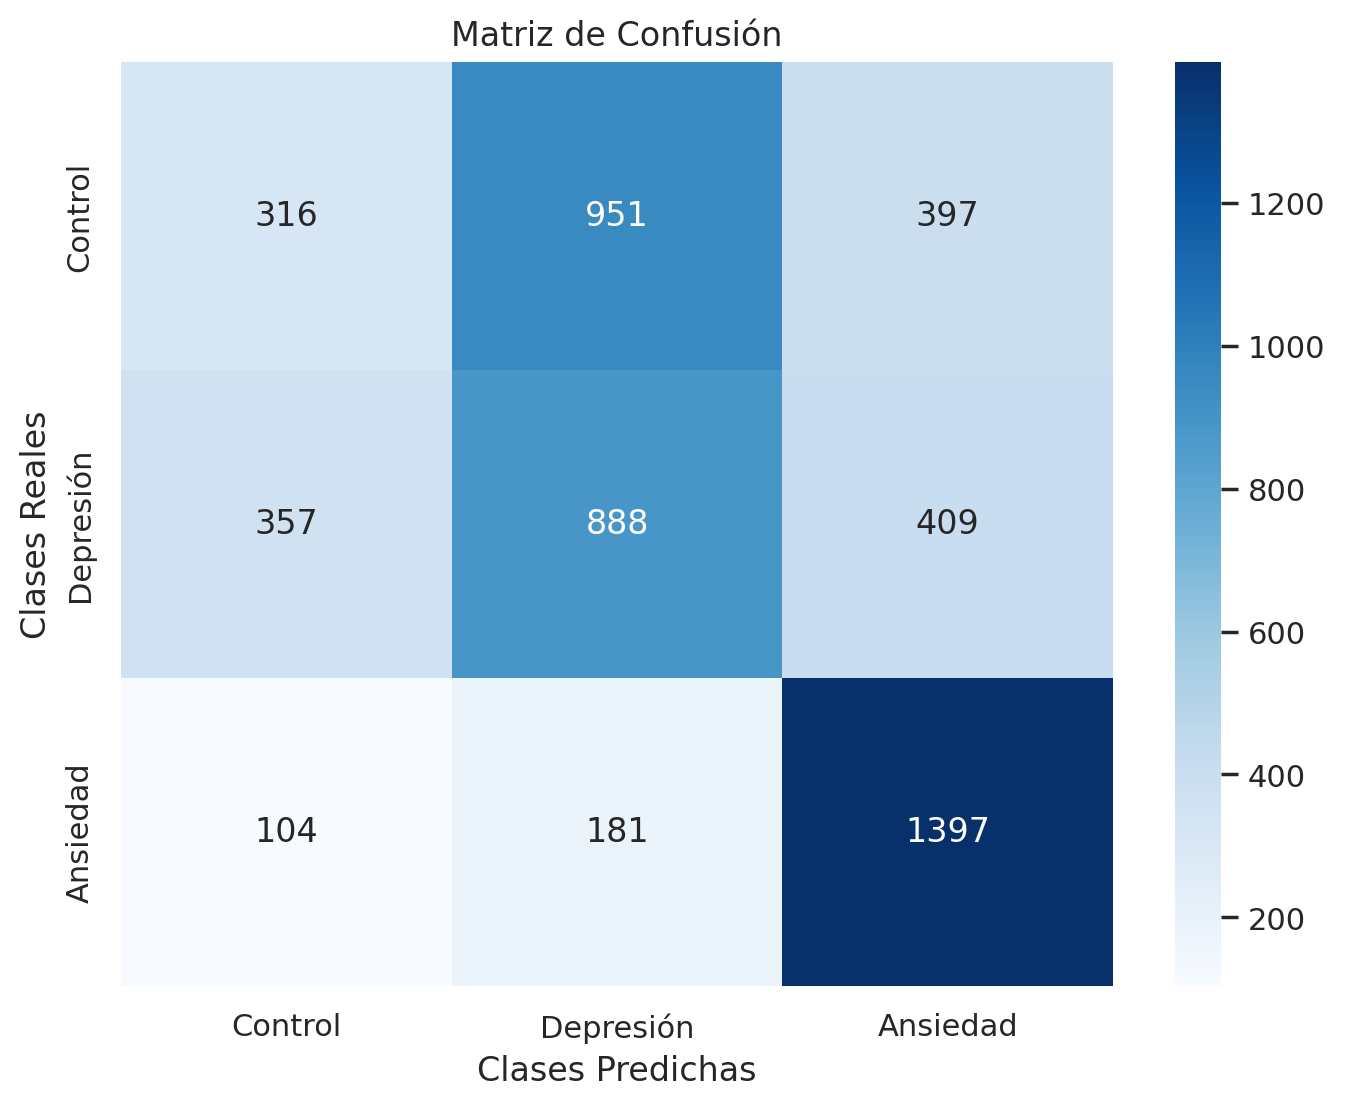

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Crear un modelo de SVM
svm_model_p = SVC(kernel='poly', degree=4, C=100, max_iter=50000, probability=False)

# Definir la estrategia de validación cruzada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Listas para almacenar métricas de entrenamiento y validación
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(range(len(X_train)), y_train):
    X_train_fold, X_val_fold = [X_train[i] for i in train_index], [X_train[i] for i in val_index]
    y_train_fold, y_val_fold = [y_train[i] for i in train_index], [y_train[i] for i in val_index]

    # Entrenar el modelo en los datos de entrenamiento del fold
    svm_model_p.fit(X_train_fold, y_train_fold)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = svm_model_p.predict(X_train_fold)

    # Calcular métricas de entrenamiento y agregarlas a las listas
    train_accuracy_scores.append(accuracy_score(y_train_fold, y_train_pred))
    train_precision_scores.append(precision_score(y_train_fold, y_train_pred, average='weighted'))
    train_recall_scores.append(recall_score(y_train_fold, y_train_pred, average='weighted'))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred, average='weighted'))

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = svm_model_p.predict(X_val_fold)

    # Calcular métricas de validación y agregarlas a las listas
    val_accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))
    val_precision_scores.append(precision_score(y_val_fold, y_val_pred, average='weighted'))
    val_recall_scores.append(recall_score(y_val_fold, y_val_pred, average='weighted'))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred, average='weighted'))

# Calcular las métricas promediadas en entrenamiento y validación
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas en entrenamiento y validación
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))

print("\nValidación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))



Entrenamiento - Accuracy: 62.82%
Entrenamiento - Precision: 64.38%
Entrenamiento - Recall: 62.82%
Entrenamiento - F1 Score: 60.26%

Validación - Accuracy: 53.03%
Validación - Precision: 50.99%
Validación - Recall: 53.03%
Validación - F1 Score: 49.52%


In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Modelos ya entrenados'
model_filename = 'TWEETS_depresivos (SVM_p (Bow)).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(svm_model_p, model_path_p)

# matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
# y las columnas a las predicciones.
#
cm = confusion_matrix(y_val, y_pred)

# Obtiene la proporción real de comentarios positivos,
# y la proporción etiquetados.
#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[ 256 1047  361]
 [ 290  991  373]
 [  72  211 1399]] 

Proporción de comentarios positivos: 1.00
Proporción de comentarios positivos etiquetados: 0.41


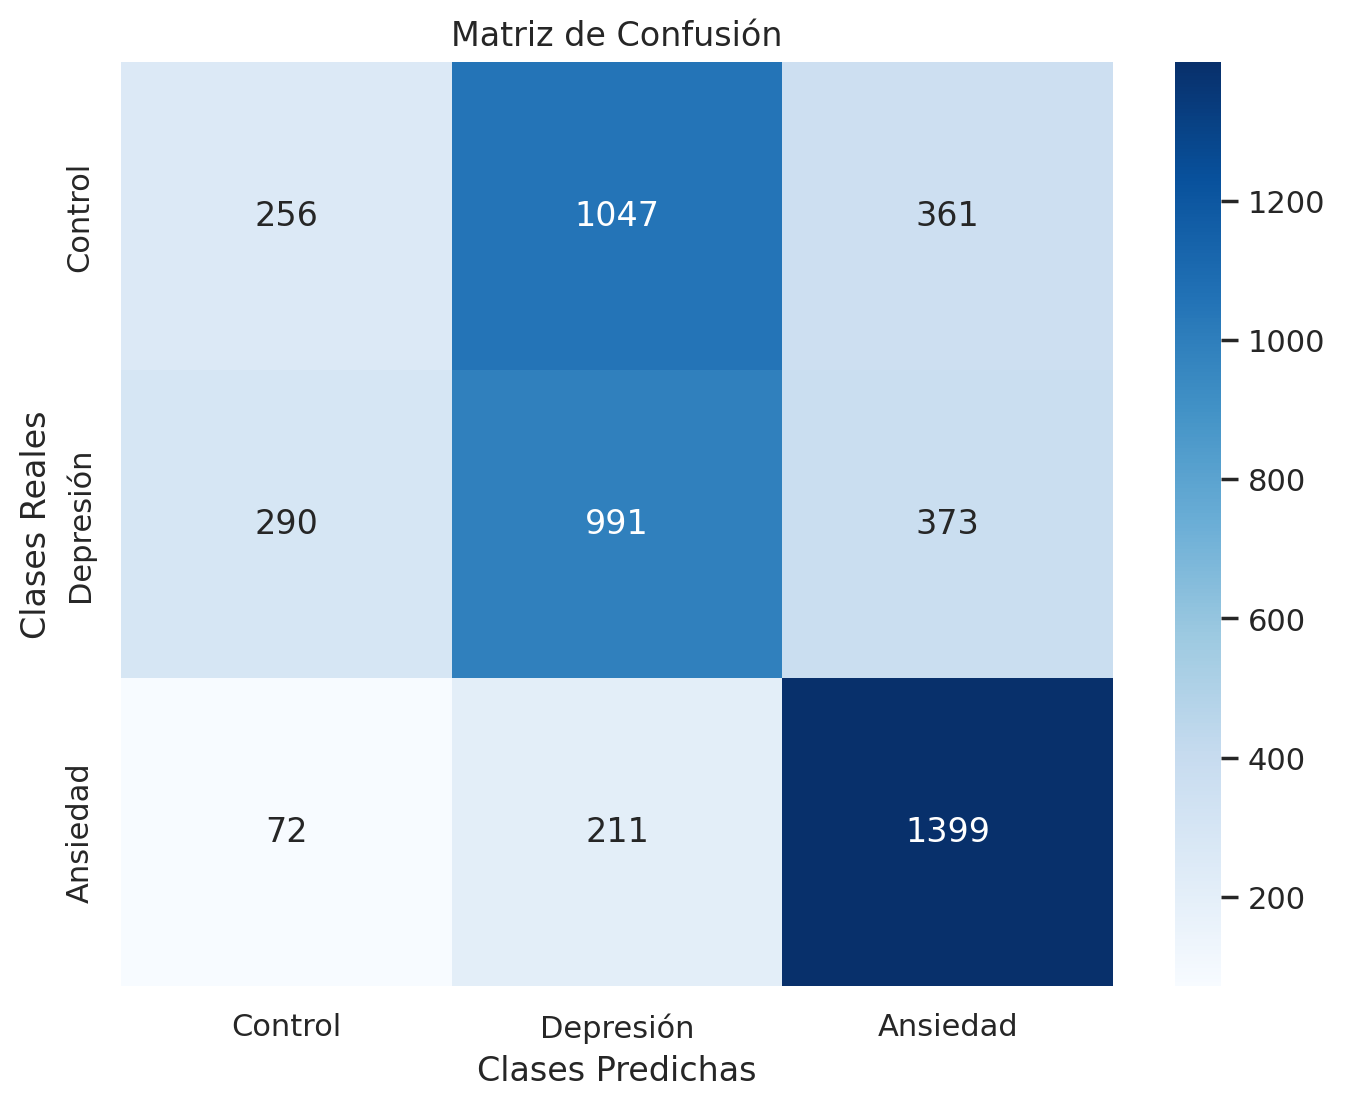

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()